### Motivation
降維可以幫助抵抗機器學習最常遇到的問題，龐大的維度規模。

#### MNIST digits database
手寫數位資料庫，握們使用Yann LeCun網站的資料集。
這個資料集可以分成三個子集合，50000實例的訓練集，10000實例驗證集，10000實力的測試集。所有的實例都已經有標籤了。

這資料集包含28x28 pixel的手寫圖片。每個單資料點(圖片)可以數字矩陣來傳送，數字代表著每pixel的深度。也就是28x28矩陣對應28x28 pixel圖。

我們可以平面化每個矩陣成28*28，784維度向量

向量中的每個元素都是0到1之間的浮點樹，代表每個pixel的強度。0是黑色1是白色。標籤號碼為0-9代表圖片中的數字

In [1]:
#import lib

import numpy as np 
import pandas as pd
import os,time
import pickle, gzip

#data viz
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
import matplotlib as mpl

# data prep and model evaluation
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

#algo
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb


import tensorflow as tf

#### Load MNIST datasets


In [2]:
current_path = os.getcwd()
file = '\\datasets\\mnist_data\\mnist.pkl.gz'

f = gzip.open(current_path+file,'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()
validation_set

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([3, 8, 6, ..., 5, 6, 8], dtype=int64))

In [3]:
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0],validation_set[1]
X_test, y_test = test_set[0],test_set[1]

#### Verify shapeof datasets

In [4]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [5]:
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train)+len(X_validation)+len(X_test))

In [6]:
X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.DataFrame(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.DataFrame(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.DataFrame(data=y_test, index=test_index)


#### Explore data


In [7]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
y_train

,0
0,5
1,0
2,4
3,1
4,9
...,...
49995,5
49996,0
49997,8
49998,4


In [9]:
def view_digit(example):
    label = y_train.loc[example]
    image = X_train.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d   Label: %d'%(example,label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

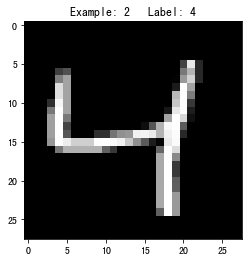

In [10]:
view_digit(2)

#### 線性投影 v.s. 流形學習
兩種最主要的降維分支。

線性投影:
從高維度將資料投影到低維度空間，
例子:<br/>PCA<br/> sigular value decomposition<br/> random projection<br/>

流形學習:
非線性降維，例如:<br/>isomap(學習兩點中曲線距離而非歐式距離)<br/>MDS(multidimensional scaling)<br/> Locally linear embedding(LLE)<br/> t-distributed stochastic neighbor embedding(t-SNE)<br/> dictionary learning
<br/>random trees embedding<br/> independent component analysis

### Principal Component Analysis
有許多種的PCA，包含standard PCA, incremental PCA, sparse PCA, kernal PCA

##### PCA concept
最常見的線性降維技術。演算法會找出能夠保存最多變異(重要訊息)的低維度代表。

PCA利用特徵來解決相關性。如果特徵子集合之間的相關性很高，PCA會試著將高度相關特徵組合在一起，用較少的線性部相關特徵展現資料，找出原本高維資料的最大變異的位址並且將他們投影到低維度空間。這些新展開的資料也稱為主成分。

有這些元素，我們可以重塑原本特徵，不完全是重塑但非常接近。PCA在優化元素時會主動嘗試最小化重塑的偏差。

在MNIST案例中，原本特徵有784維度(d 維度)，PCA將之投影到k維度子空間並且保存最多重要資訊，K維度也稱為主成分。

同時也會減少資料的大小，增加機器學習的表現。
通常我們會先正則化資料確保特徵會在相對的大小，在MNIST資料集中已經事先將特徵正則化，大小介於0-1。


In [11]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components,whiten=whiten,random_state=random_state)


#### 套用 PCA
先設定主成分維原本資料維度(i.e. 784)，PCA會抓取重要資訊開始產生主成分。一旦元素產生，我們會決定有多少的主成分被萃取到。


In [12]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data= X_train_PCA, index = train_index)
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.461486,-1.246855,0.046273,-2.151945,-0.247279,-0.925423,0.889330,0.507176,-1.541691,0.689369,...,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.769952e-05,0.000000e+00,-0.000000e+00,-0.000000e+00
1,3.921789,-1.251975,2.335259,-1.340886,-3.421518,-0.725724,-0.206345,-0.345285,0.134086,0.595475,...,4.742170e-09,3.580562e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.123725e-07,9.395818e-07,3.014860e-07,-9.617160e-09
2,-0.203721,1.547937,-0.980331,2.039093,-1.079877,0.112884,-3.312348,1.403171,-0.592898,-0.763839,...,-4.074979e-09,1.525597e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.025918e-07,-1.396577e-06,-2.071702e-06,9.332764e-08
3,-3.148450,-2.296099,1.091154,0.484597,0.066825,2.778972,-1.834356,-0.174753,1.166451,0.052855,...,-2.637537e-09,-1.327225e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.694219e-07,2.036669e-06,6.437483e-07,-1.065743e-06
4,-1.442739,2.871986,0.175652,-0.976909,0.302757,0.120654,-0.376723,-1.478132,1.003752,0.540808,...,2.856352e-08,1.209660e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.287487e-07,5.551837e-06,-2.360454e-06,1.661697e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1.147555,-1.972690,-3.739122,1.209665,-0.312002,-0.893656,1.491477,0.013916,-0.385557,-2.202909,...,-1.235761e-09,-7.058333e-09,7.806817e-09,-8.796969e-09,3.067120e-10,-9.134856e-10,1.711371e-08,5.020282e-09,3.332030e-10,7.047642e-10
49996,1.416381,-0.252682,-0.809476,-0.523546,-3.905657,0.187955,-0.449568,-1.231870,-0.104625,0.510858,...,3.175924e-08,6.614789e-08,-4.256530e-09,-6.259228e-09,-3.637915e-09,-1.452559e-09,-1.338935e-08,4.821441e-09,-9.016426e-09,2.229096e-09
49997,-1.425329,-1.957541,-2.551116,0.094593,0.654068,-0.603917,0.312860,-0.047757,0.994548,0.222441,...,1.209317e-08,3.002637e-09,4.055785e-09,5.872140e-09,-4.875055e-09,-2.666693e-09,6.463983e-09,2.125245e-09,-3.535153e-10,-2.285242e-09
49998,-1.507546,1.025468,0.107841,0.276075,2.285549,-0.590754,-0.676684,-0.062367,0.050038,1.578244,...,-6.101628e-09,-2.223911e-09,3.903040e-09,-4.990766e-09,-1.209658e-09,-2.191153e-10,3.466794e-09,2.763308e-09,-2.949933e-09,6.518028e-10


#### 評估PCA
因為沒有完全把維度降到極致

In [13]:
print('Variance Explained by all 784 principal components: ', 
     sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  0.9999999839005775


In [14]:
importanceOfPrincipalComponents = pd.DataFrame(data = pca.explained_variance_ratio_)
print(importanceOfPrincipalComponents)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T
print(importanceOfPrincipalComponents)


                0
0    9.744351e-02
1    7.059821e-02
2    6.216072e-02
3    5.379511e-02
4    4.858052e-02
..            ...
779  1.254976e-16
780  1.224751e-16
781  5.811719e-17
782  4.772935e-17
783  1.306506e-17

[784 rows x 1 columns]
        0         1         2         3         4         5         6    \
0  0.097444  0.070598  0.062161  0.053795  0.048581  0.043196  0.032776   

        7         8         9    ...           774           775  \
0  0.028864  0.027688  0.023659  ...  1.254976e-16  1.254976e-16   

            776           777           778           779           780  \
0  1.254976e-16  1.254976e-16  1.254976e-16  1.254976e-16  1.224751e-16   

            781           782           783  
0  5.811719e-17  4.772935e-17  1.306506e-17  

[1 rows x 784 columns]


In [15]:
print('Variance Captured by First 10 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)
print('Variance Captured by First 100 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:99].sum(axis=1).values)
print('Variance Captured by First 200 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:199].sum(axis=1).values)
print('Variance Captured by First 300 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:299].sum(axis=1).values)

Variance Captured by First 10 Principal Components:  [0.4887615]
Variance Captured by First 20 Principal Components:  [0.6439795]
Variance Captured by First 50 Principal Components:  [0.8248605]
Variance Captured by First 100 Principal Components:  [0.91465837]
Variance Captured by First 200 Principal Components:  [0.9665007]
Variance Captured by First 300 Principal Components:  [0.9862489]


可以看出來前10個元素就包含了百分之50的變異數
前100就有90%

<AxesSubplot:>

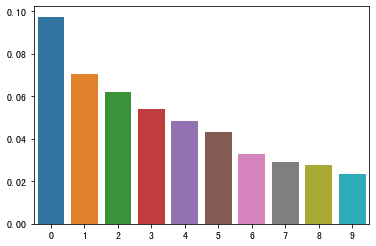

In [16]:
sns.barplot(data=importanceOfPrincipalComponents.loc[:,0:9])

來演示PCA的有效和簡潔的抓舉資料中的變異數，畫出二維來觀察。特別是展示出散點圖第一和第二主要元素來利用真實標籤重點標註起來。

In [17]:
def scatterplot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data = xDF.loc[:,0:1], index = xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis = 1, join='inner')
    tempDF.columns = ['First Vector','second vector','label']
    sns.lmplot(x='First Vector', y ='second vector',hue = 'label', data=tempDF,fit_reg = False)
    ax = plt.gca()
    ax.set_title('Seperation of observation using' + algoName)

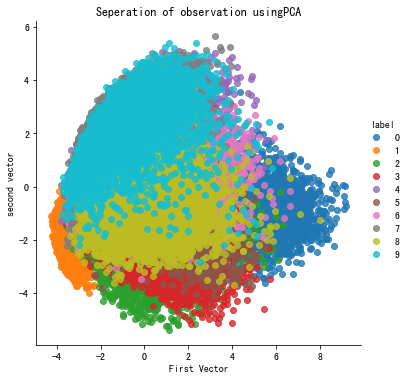

In [18]:
scatterplot(X_train_PCA,y_train,'PCA')

觀察上圖，只有頭兩個主成分，PCA在空間中分割端點有不錯的成效，相似的點大多被歸類在很靠近的距離。也就是說相同數字的圖片彼此之間很接近。

PCA在沒有任何標籤的支持之下完成上述的圖。非監督式學習抓取underlying結構的資料有很優越的力度，幫助發覺標籤空缺所產生的隱藏pattern。

如果我們利用從原784特徵集中萃取最重要的兩個特徵執行相同二維散點圖，使用監督式學習的模型訓練，分離的結果會不顯著。

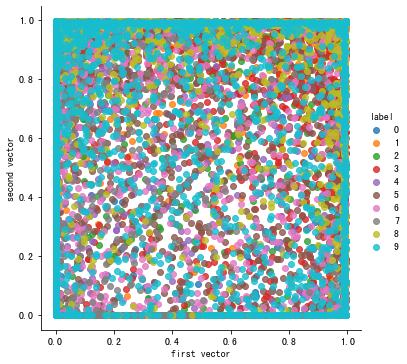

In [19]:
X_train_scatter = pd.DataFrame(data=X_train.loc[:,[350,406]],index=X_train.index)
X_train_scatter = pd.concat((X_train_scatter, y_train), axis=1, join='inner')
X_train_scatter.columns=['first vector','second vector','label']

sns.lmplot(x='first vector',y='second vector',hue='label', data=X_train_scatter, fit_reg=False)


兩張圖很明顯看出來PCA在學習底層架構的資料集會有很強大的功用。即使現在只使用二維的資料，我們可以開始根據顯示的數字有效的分離照片。

#### NOTE:
PCA不只幫助我們發現隱藏的pattern且更簡易的閱讀，同時幫助減少特徵集的大小，在時間和計算資源上大大的減少成本。
有MNIST資料集，因為資料集非常小，只有784特徵值和50000觀察項，因此在訓練時間的沒有太過顯著的差別。

但若資料集的特徵和項目過大，降維會大大的影響效率。
PCA會丟失掉一些原資料特徵集資訊，但是是很有智慧的選擇。模型在訓練的時候使用PCA降維過後的特徵集有可能在準確度的表現沒辦法像利用所有特徵集訓練的模型還要好。

這樣的trades-off是在選擇使否降維的關鍵。速度或是準確度

#### Incremental PCA
當資料集非常龐大且不能存放進記憶體，可以使用漸進增長的PCA，每一個batch都可以fit in 記憶體，每batch大小可以手動設定或自動。

這種形式的batch PCA也就是incremental PCA，

In [20]:
# incremental
from sklearn.decomposition import IncrementalPCA

n_components =784
batch_size = None
incrementalPCA = IncrementalPCA(n_components=n_components, 
                               batch_size = batch_size)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA

array([[ 4.61509466e-01,  1.24686481e+00, -4.63732404e-02, ...,
        -4.09257903e-13,  2.97977899e-11, -9.41033915e-08],
       [ 3.92165162e+00,  1.25165147e+00, -2.33550474e+00, ...,
        -2.96705709e-14,  1.65615348e-12, -8.65144221e-10],
       [-2.03710877e-01, -1.54788359e+00,  9.80400124e-01, ...,
        -9.56293681e-15,  2.62811917e-13, -5.06510083e-10],
       ...,
       [-1.42506107e+00,  1.95785620e+00,  2.55120618e+00, ...,
         4.37009446e-14, -4.72842817e-12,  1.76738771e-09],
       [-1.50742748e+00, -1.02531407e+00, -1.07808318e-01, ...,
         7.05215884e-16,  1.01852468e-12,  1.22814529e-09],
       [-1.39639624e+00,  6.46483181e-01,  2.57306673e+00, ...,
         4.43563277e-14, -4.14267987e-12, -6.17867445e-10]])

In [21]:
X_train_incrementalPCA = pd.DataFrame(data=X_train_incrementalPCA, index = train_index)

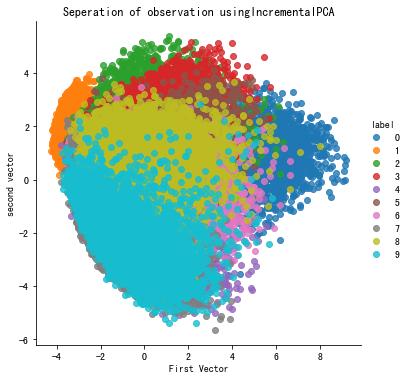

In [22]:
X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA = pd.DataFrame(data=X_validation_incrementalPCA, index= validation_index)
scatterplot(X_train_incrementalPCA,y_train,'IncrementalPCA')

### Sparse PCA

標準的PCA演算法在所有的輸入變數中尋找線性組合，減少原本特徵空間的密度。

但有些機器學習的問題，維度的稀疏姓會是首要選擇。Sparse PCA保留了維度的稀疏姓，利用名為alpha的超參數，SPARSE PCA利用部分的輸入變數尋找線性組合。

不過Sparse PCA訓練過程中一般會比正常的PCA還要慢一些，因此在這裡我們只訓練10000筆資料

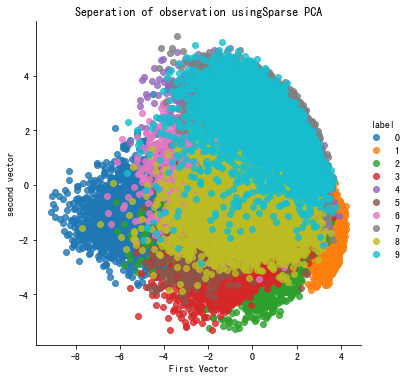

In [23]:
from sklearn.decomposition import SparsePCA

n_components = 100
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, \
                alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:10000,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=train_index)

X_validation_sparsePCA = sparsePCA.transform(X_validation)
X_validation_sparsePCA = \
    pd.DataFrame(data=X_validation_sparsePCA, index=validation_index)

scatterplot(X_train_sparsePCA, y_train, "Sparse PCA")

可以看出圖和上面標準PCA索賄化出來的不太一樣，兩個PCA產生的主成分不同導致再分割點的時候也有不同。

### Kernel PCA
標準PCA、增長型PCA、Sparse PCA皆利用線性投影到低維度空間，當然也存在非線性PCA - Kernel PCA，將原資料配對執行類似的函數來表現非線性降維。

利用學習這類似函數，核心PCA會去測畫隱含特徵空間且主要的資料點皆存在並創造一個比原特徵集維度小的隱含特徵空間。 這方法針對屬於非線性分的原特徵集十分有效。

核心PCA演算法，我們需要設定需求元素的數量，核心的種類和和核心的係數(gamma)。最有名的核心式半徑基礎函數核心，最常用的方法-RBF核心。


 By learning this similarity function (known as the kernel method), kernel PCA maps the implicit feature space where the majority of data points lie and creates this implicit feature space in a much smaller number of dimensions than the dimensions in the original feature set. This method is especially effective when the original feature set is not linearly separable.
 
 For the kernel PCA algorithm, we need to set the number of components we desire, the type of kernel, and the kernel coefficient, which is known as the gamma. The most popular kernel is the radial basis function kernel, more commonly referred to as the RBF kernel. This is what we will use here:

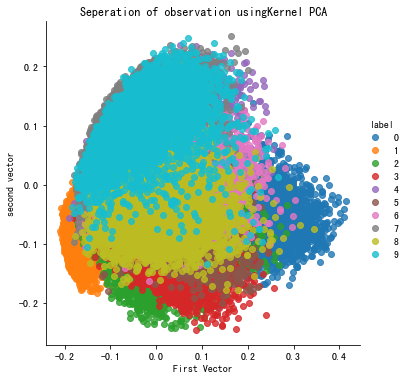

In [24]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 100
kernel = 'rbf'
gamma = None
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                      gamma=gamma, n_jobs=n_jobs, random_state=random_state)

kernelPCA.fit(X_train.loc[:10000,:])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA,index=train_index)

X_validation_kernelPCA = kernelPCA.transform(X_validation)
X_validation_kernelPCA = \
    pd.DataFrame(data=X_validation_kernelPCA, index=validation_index)

scatterplot(X_train_kernelPCA, y_train, "Kernel PCA")

In [25]:
from sklearn.decomposition import KernelPCA

n_components = 100
kernel = 'rbf'
gamma = None
n_jobs = 1
random_state = 2018

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, n_jobs=n_jobs, random_state=random_state)

kernelPCA.fit(X_train.loc[:10000,:])

KernelPCA(kernel='rbf', n_components=100, n_jobs=1, random_state=2018)

In [26]:
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, index = train_index)

X_validation_kernel = kernelPCA.transform(X_validation)
X_validation_kernel = pd.DataFrame(data = X_validation_kernel, index = validation_index)

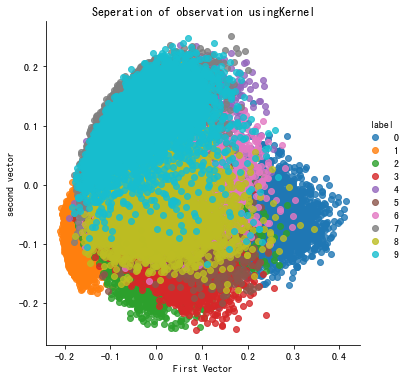

In [27]:
scatterplot(X_train_kernelPCA, y_train,algoName = 'Kernel')

上面二維的kernelPCA 繪圖和線性PCA真得幾乎一模一樣


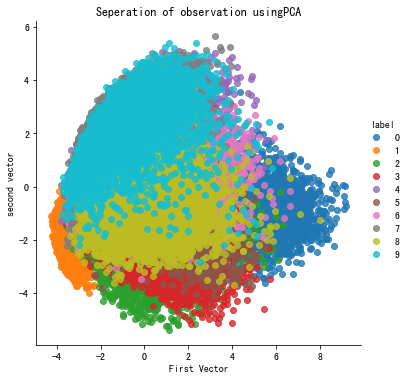

In [28]:
scatterplot(X_train_PCA,y_train,'PCA')

#### 奇異值分解

另外一中學習底層資料架構的方式就是降低原始特徵矩陣的秩rank，原始矩陣可以利用向量線性組合被重塑成小秩的矩陣。- SVD 

產生小秩矩陣，SVD保存原矩陣含有最重要資訊的向量(i.e.最大奇異值)，矩陣的秩月校可以擷取出原特徵空間最多重要元素。


In [29]:
from sklearn.decomposition import TruncatedSVD
n_components = 200
n_iter =5
algorithm = 'randomized'
random_state= 2018

svd = TruncatedSVD(n_components = n_components, n_iter = n_iter, algorithm = algorithm, random_state = random_state)
print('X_train:\n',X_train)
X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data = X_train_svd, index = train_index)
print('\n X_train_svd: \n', X_train_svd)

X_train:
        0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
49995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
49996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
49997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
49998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
49999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783 

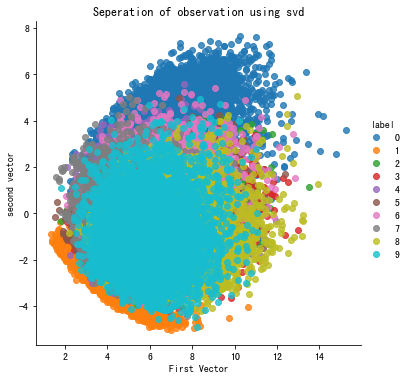

In [30]:
X_validation_svd =  svd.transform(X_validation)
X_validation_svd = pd.DataFrame(data=X_validation, index = validation_index)
scatterplot(X_train_svd,y_train, ' svd')

### 隨機投影
#### 高斯隨機投影
可以指定在降維特徵空間中特定的元素，也可以設定超參數eps。eps控制

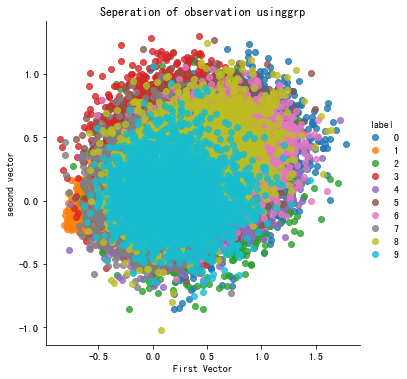

In [31]:
from sklearn.random_projection import GaussianRandomProjection

n_components = 'auto'
random_state=2018
eps = 0.5

GRP = GaussianRandomProjection(n_components=n_components,random_state=random_state,eps=eps)

x_train_grp = GRP.fit_transform(X_train)
x_train_grp = pd.DataFrame(data = x_train_grp, index = train_index)
scatterplot(x_train_grp, y_train,'grp')

### 稀疏隨機投影
隨機投影也有稀疏的版本，保持轉換特徵集過程的稀疏維度，通常效率會比較好。

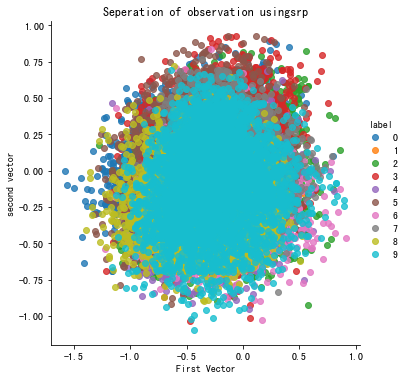

In [32]:
from sklearn.random_projection import SparseRandomProjection

n_components = 'auto'
density= 'auto'
eps = 0.5
dense_output = False
random_state = 2018

SRP = SparseRandomProjection(n_components=n_components, eps=eps,random_state=random_state)

X_train_srp = SRP.fit_transform(X_train)
X_train_srp = pd.DataFrame(data=X_train_srp, index=train_index)
scatterplot(X_train_srp,y_train,'srp')

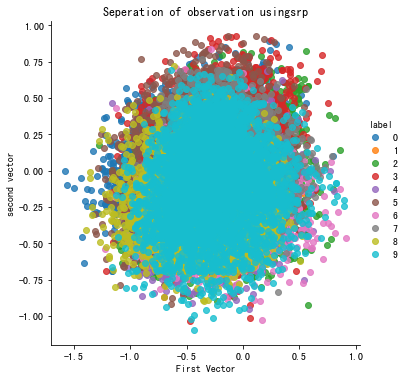

In [33]:
SRP = SparseRandomProjection(n_components=n_components,density=density,dense_output=dense_output, eps=eps,random_state=random_state)

X_train_srp = SRP.fit_transform(X_train)
X_train_srp = pd.DataFrame(data=X_train_srp, index=train_index)
scatterplot(X_train_srp,y_train,'srp')

### Isomap
屬於非線性的降維，也是流形學習的一種。
Isomap利用配對方式計算curved 或 geodesic 距離學習並且遷入到新的低維度特徵集。

In [34]:
from sklearn.manifold import Isomap

n_neighbors = 5
n_components = 10
n_jobs = 4

isomap = Isomap(n_neighbors=n_neighbors, n_jobs=n_jobs, n_components = n_components)

X_train_isomap = isomap.fit_transform(X_train)
X_train_isomap = pd.DataFrame(data=X_train_isomap,index=train_index)
scatterplot(X_train_isomap,y_train,'isomap')

MemoryError: Unable to allocate 18.6 GiB for an array with shape (50000, 50000) and data type float64

* 因為速度太慢，將fit的訓練資料數下降

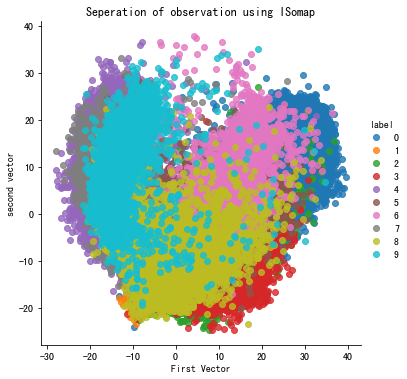

In [35]:
isomap = Isomap(n_neighbors=n_neighbors, n_jobs=n_jobs, n_components = n_components)
isomap.fit(X_train.loc[:5000,:])
X_train_isomap = isomap.transform(X_train)
X_train_isomap = pd.DataFrame(data = X_train_isomap, index = train_index)

scatterplot(X_train_isomap, y_train, ' ISomap')

### Multidimensional scaling
MDS 是非線性降維的方式，學習原資料集中相似的端點，利用similarity 學習方式。

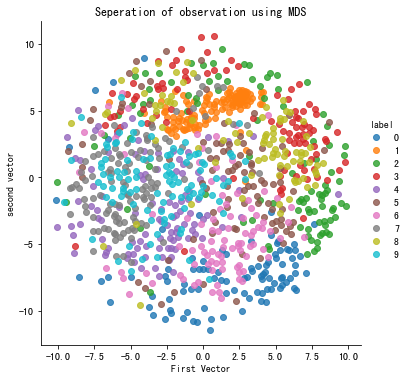

In [36]:
from sklearn.manifold import MDS

n_components =2
n_init = 12 
max_iter = 1200
n_jobs = 4
random_state =2018

mds = MDS(n_components=n_components, n_init=n_init, max_iter=max_iter,
         n_jobs=n_jobs, random_state=random_state)

X_train_mds = mds.fit_transform(X_train.loc[:1000,:])
X_train_mds = pd.DataFrame(data = X_train_mds,index = train_index[0:1001])

scatterplot(X_train_mds,y_train, ' MDS')

### Locally linear Embedding 
另外一種非線性降維的approach，從原特徵集投影到低維度空間的時候保留本地鄰居的距離。 LLE 從原高維非線性結構資料中分割資料成較小的元素並將每個元素以線性嵌入的方式模型化，

### t-Distributed Stochastic Neighbor Embedding 
t-SNE 也是非線性降維視覺化高維度資料，t-SNE成功的把資料轉換成2或3維空間，相似的點都會被模型塑造得更接近。

建構兩個機率分布，其中一個將高維度的資料配對起來，另外一個配對低維度的資料。因此相似的點就會有比較高的機率。

在真實案例當中， 最好的使用方式可以先利用其它降維的方式，在來使用TSNE。減少特徵當中的雜訊可以加速演算法計算速度。

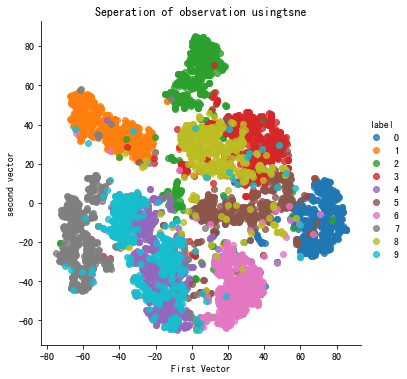

In [37]:
from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration =12
init=  'random'
random_state= 2018

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, \
            perplexity=perplexity, early_exaggeration=early_exaggeration, \
            init=init, random_state=random_state)

X_train_tSNE = tSNE.fit_transform(X_train_PCA.loc[:5000,:9])
X_train_tSNE = pd.DataFrame(data =X_train_tSNE, index = train_index[:5001])

scatterplot(X_train_tSNE, y_train, 'tsne')

### Dictionary learning 
字典學習，主要是學習已用稀疏表示方式的原資料，最終呈現結果的矩陣稱之dictionary，字典當中的向量稱atoms。atoms是二元向量，0和1。每個原資料的實例中的atom總和可以被重塑成權重。
